# This module is for training and parameter tunning of the LSTM model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential  
from keras.layers.core import Dense  
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from utils import *
%matplotlib inline

In [3]:
# load normal training dataset and first normal validation dataset
train = pd.read_csv('../train_treated.csv', index_col=0)
val = pd.read_csv('../val1_treated.csv', index_col=0)

# Grid search
In this section, a grid search was executed to search for the optimal number of previous steps (lookback) and the number of hidden neurons in the neural network.

In [6]:
# grid-search for optimal number of previous steps and number of hidden neurons
lookbacks = [1, 2, 5, 10, 15]
hiddens = [100, 200, 300, 400]

# bm to record benchmark results
bm = pd.DataFrame(columns = ['lookback', 'hidden_neurons', 'train_loss', 'val_loss'])

count = 0
for lookback in lookbacks:
    trainX, trainY = createDataset(train, lookback)
    valX, valY = createDataset(val, lookback)
    
    for hidden in hiddens:
        print("\n\ntraining with {} lookback and {} hidden neurons\n\n".format(lookback, hidden))
        model = Sequential()  
        model.add(LSTM(hidden, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
        model.add(Dense(trainY.shape[1], activation='linear'))  
        model.compile(loss="mean_squared_error", optimizer="rmsprop")
        
        earlyStopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
        history = model.fit(trainX,
                            trainY,
                            batch_size=450,
                            epochs=100,
                            verbose=1,
                            validation_data=(valX, valY),
                            callbacks=[earlyStopping])
        bm.loc[count, :] = [lookback, hidden, history.history['loss'][-1], history.history['val_loss'][-1]]
        count += 1



training with 1 lookback and 100 hidden neurons


Train on 44831 samples, validate on 11198 samples
Epoch 1/100
44831/44831 [==============================] - 2s 51us/step - loss: 0.1077 - val_loss: 0.0397
Epoch 2/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0170 - val_loss: 0.0331
Epoch 3/100
44831/44831 [==============================] - 1s 22us/step - loss: 0.0103 - val_loss: 0.0272
Epoch 4/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0069 - val_loss: 0.0233
Epoch 5/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0048 - val_loss: 0.0202
Epoch 6/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0036 - val_loss: 0.0178
Epoch 7/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0030 - val_loss: 0.0164
Epoch 8/100
44831/44831 [==============================] - 1s 23us/step - loss: 0.0026 - val_loss: 0.0150
Epoch 9/100
44831/44831 [=========================

Epoch 2/100
44750/44750 [==============================] - 5s 106us/step - loss: 0.0044 - val_loss: 0.0215
Epoch 3/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0025 - val_loss: 0.0184
Epoch 4/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0018 - val_loss: 0.0151
Epoch 5/100
44750/44750 [==============================] - 5s 106us/step - loss: 0.0014 - val_loss: 0.0135
Epoch 6/100
44750/44750 [==============================] - 5s 109us/step - loss: 0.0012 - val_loss: 0.0120
Epoch 7/100
44750/44750 [==============================] - 5s 105us/step - loss: 0.0010 - val_loss: 0.0104
Epoch 8/100
44750/44750 [==============================] - 5s 106us/step - loss: 9.1178e-04 - val_loss: 0.0101
Epoch 9/100
44750/44750 [==============================] - 5s 105us/step - loss: 8.1426e-04 - val_loss: 0.0096
Epoch 10/100
44750/44750 [==============================] - 5s 105us/step - loss: 7.4879e-04 - val_loss: 0.0098
Epoch 11/100
44750/44750

In [89]:
# print benchmark to choose the optimal parameters
bm.to_csv('../bm.csv', index=False)
bm

,lookback,hidden_neurons,train_loss,val_loss
0,1,100,0.000242591,0.000742731
1,1,200,0.000335078,0.000822069
2,1,300,0.000452783,0.000852196
3,1,400,0.000482217,0.00081254
4,2,100,0.000394912,0.00109703
5,2,200,0.000706654,0.00156105
6,2,300,0.0011091,0.00257069
7,2,400,0.00081258,0.00157814
8,10,100,0.000627996,0.00281072
9,10,200,0.000517752,0.00260395


# Model training
In this section, we use the optimized parameters obtained by the grid search to train an LSTM model.

In [43]:
# Grid-search results
lookback = 10
hidden_neurons = 300

# create training and validation data correspondant to the choosen number of steps
trainX, trainY = createDataset(train, lookback)
valX, valY = createDataset(val, lookback)

# define the architecture of neural network
model = Sequential()  
model.add(LSTM(hidden_neurons, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))  
model.add(Dense(trainY.shape[1], activation='linear'))  
model.compile(loss="mean_squared_error", optimizer="rmsprop") 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 300)               376800    
_________________________________________________________________
dense_2 (Dense)              (None, 13)                3913      
Total params: 380,713
Trainable params: 380,713
Non-trainable params: 0
_________________________________________________________________


In [44]:
# use validation set for early stopping to avoid overfitting
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
# use checkpoints to save the best model
checkpoint = ModelCheckpoint('../LSTM_{}_{}.model'.format(lookback, hidden_neurons), 
                             monitor='val_loss', 
                             save_best_only=True,
                             mode='min')
# train the model
history = model.fit(trainX,
          trainY,
          batch_size=450,
          epochs=100,
          verbose=1,
          validation_data=(valX, valY),
          callbacks=[earlyStopping, checkpoint])  

Train on 44750 samples, validate on 11117 samples
Epoch 1/100
44750/44750 [==============================] - 12s 257us/step - loss: 0.0193 - val_loss: 0.0173
Epoch 2/100
44750/44750 [==============================] - 11s 240us/step - loss: 0.0056 - val_loss: 0.0120
Epoch 3/100
44750/44750 [==============================] - 11s 240us/step - loss: 0.0037 - val_loss: 0.0082
Epoch 4/100
44750/44750 [==============================] - 11s 252us/step - loss: 0.0027 - val_loss: 0.0063
Epoch 5/100
44750/44750 [==============================] - 11s 247us/step - loss: 0.0022 - val_loss: 0.0059
Epoch 6/100
44750/44750 [==============================] - 11s 244us/step - loss: 0.0019 - val_loss: 0.0046
Epoch 7/100
44750/44750 [==============================] - 11s 254us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 8/100
44750/44750 [==============================] - 11s 246us/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9/100
44750/44750 [==============================] - 11s 253us/step - loss: 0.00

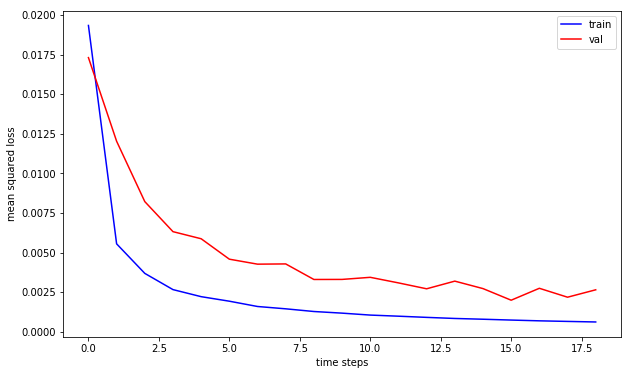

In [49]:
# plot training curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='val')
plt.legend(loc='best')
plt.xlabel("time steps")
plt.ylabel("mean squared loss")
plt.show()

In [8]:
# get the prediction of the validation dataset
pred = model.predict(valX)

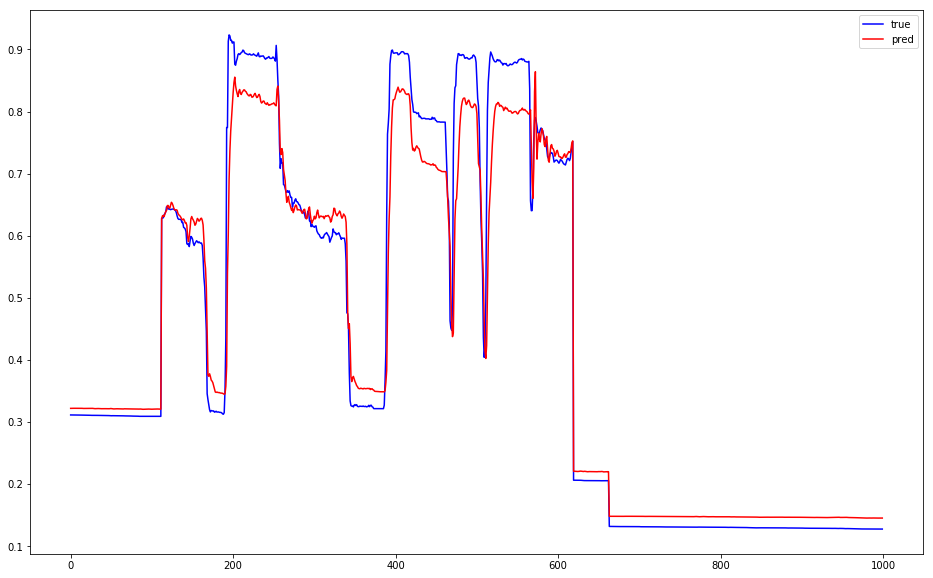

In [11]:
# plot the prediction and real value in the same graph to visualize predictive ability

# k is the coordinate of state vector
k = 0
# s and e are the start and end of period we want to see
s = 5000
e = 6000

true_ = valY[s:e, k]
pred_ = pred[s:e, k]
plt.figure(figsize=(16,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()

# Try multi-steps prediction
In this section, we try to check the performance of our model when it predicts the state vectors several steps away. To do the multi-steps prediction, the model takes each step its prediction as the truth to predict the next step. Intuitively, the error will accumulate.

In [11]:
# load model (in case that we run this section without running the previous sections)
lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

# load validation dataset
val = pd.read_csv('../val1_treated.csv', index_col=0)
valX, valY = createDataset(val, lookback)

In [13]:
pred_sequence = []

val_brokens = getBrokens(val.index)
for i in range(len(val_brokens)-1):
    X_seq = val.iloc[val_brokens[i]:val_brokens[i]+lookback, :].values
    pred_sequence += list(X_seq)
    for j in range(val_brokens[i]+lookback, val_brokens[i+1]):
        predY = model.predict(np.array([X_seq]))[0]
        pred_sequence.append(predY)
        X_seq = np.concatenate((X_seq[1:], [predY]))
pred_sequence = np.array(pred_sequence)

In [22]:
def predictSequence(model, dataX, dataY, lookforward=1):
    """Multi-steps prediction for a continuous dataset"""
    dataX, dataY = np.array(dataX), np.array(dataY)
    
    X_ = dataX[:1-lookforward+len(dataX)].copy()
    for steps in range(lookforward):
        pred_ = model.predict(X_)
        pred_ = np.reshape(pred_, (pred_.shape[0], 1, pred_.shape[1]))
        X_ = np.concatenate((X_[:, 1:, :], pred_), axis=1)
    
    true_ = dataY[lookforward-1:]
    return true_, pred_[:, 0, :]

def predictSequenceTotal(model, dataset, lookforward=1):
    """Multi-steps prediction for discontinous dataset"""
    true_sequence, pred_sequence = [], []
    brokens = getBrokens(dataset.index)
    for i in range(len(brokens)-1):
        dataX, dataY = createSequnces(dataset.iloc[brokens[i]:brokens[i+1], :], lookback)
        t_s, p_s = predictSequence(model, dataX, dataY, lookforward)
        true_sequence.append(t_s)
        pred_sequence.append(p_s)
    return np.concatenate(true_sequence), np.concatenate(pred_sequence)

In [29]:
# 1-step prediction
true_sequence, pred_sequence = predictSequenceTotal(model, val, 1)

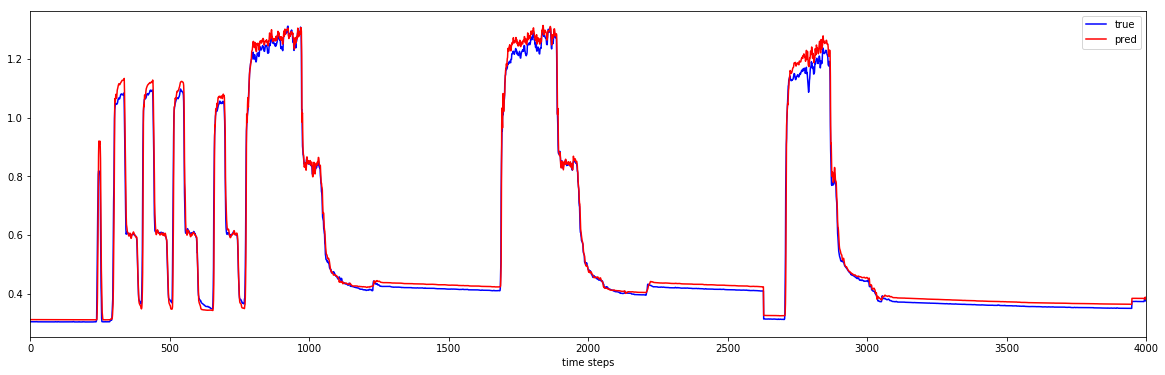

In [37]:
# visualize how well the model works for 1-step prediction
k = 2
s = 7000
e = 11000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(20,6))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.xlabel('time steps')
plt.xlim((0, 4000))
plt.show()

In [16]:
# 2-steps prediction
true_sequence, pred_sequence = predictSequenceTotal(model, val, 2)

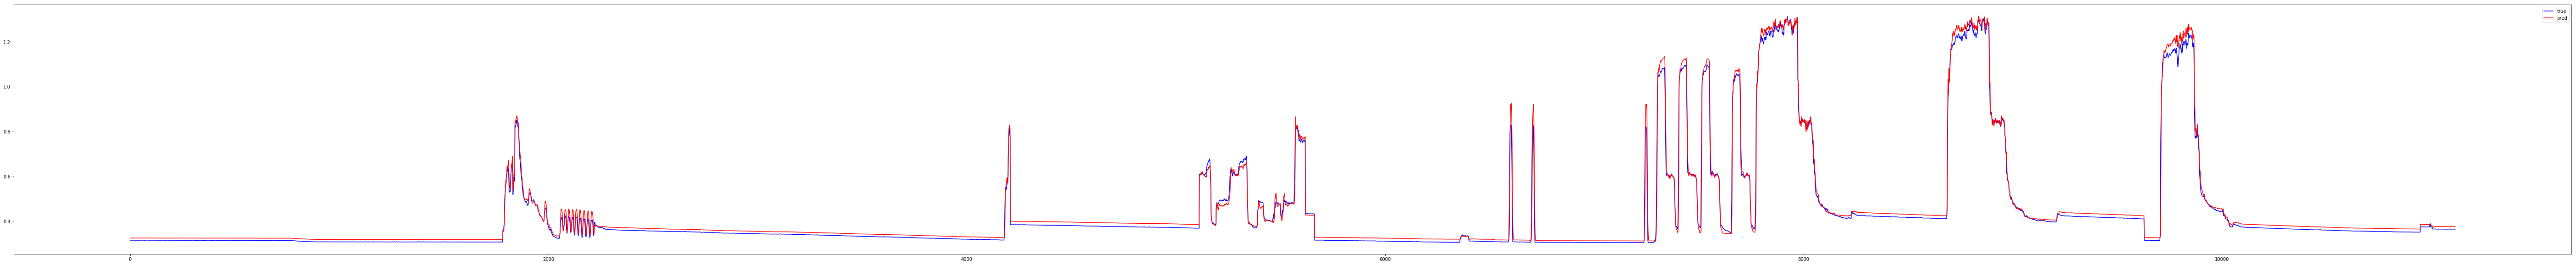

In [25]:
# visualize how well the model works for 2-steps prediction
k = 2
s = 0
e = 25000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(100,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()

In [26]:
# 5-steps prediction
true_sequence, pred_sequence = predictSequenceTotal(model, val, 5)

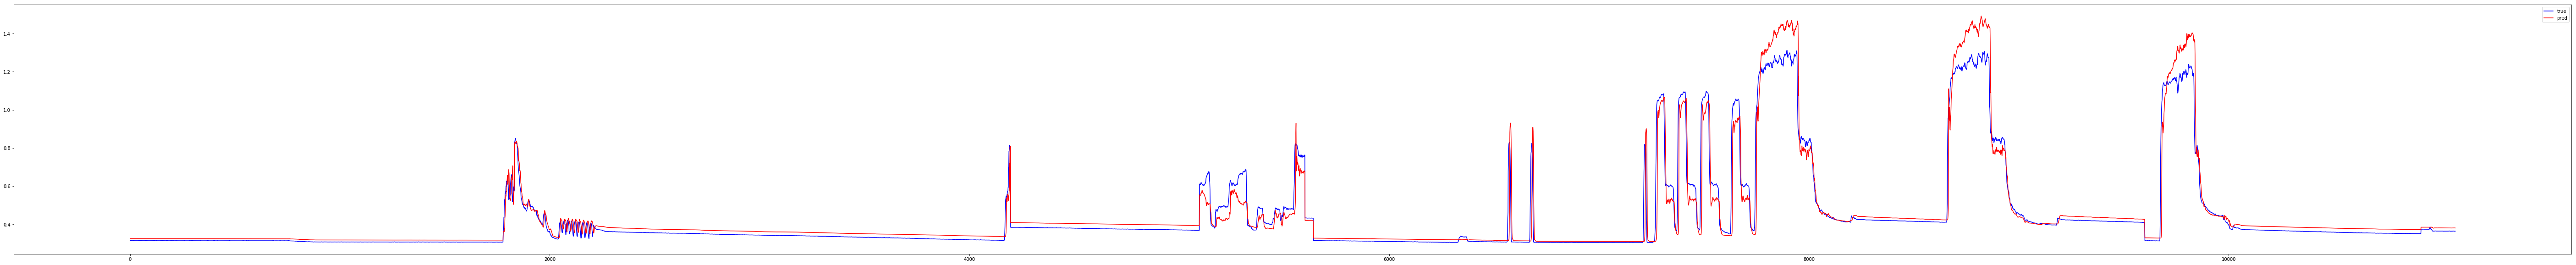

In [27]:
# visualize how well the model works for 5-steps prediction
k = 2
s = 0
e = 25000
true_ = true_sequence[s:e, k]
pred_ = pred_sequence[s:e, k]
plt.figure(figsize=(100,10))
plt.plot(true_, color='b', label='true')
plt.plot(pred_, color='r', label='pred')
plt.legend(loc='best')
plt.show()